In [1]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [2]:
# Use only if interested

import kagglehub
pratik2901_multiclass_weather_dataset_path = kagglehub.dataset_download('pratik2901/multiclass-weather-dataset')

print('Data source import complete.')


100%|██████████| 91.4M/91.4M [00:00<00:00, 142MB/s]

Extracting files...


Data source import complete.


In [9]:
print(pratik2901_multiclass_weather_dataset_path)
!mv /root/.cache/kagglehub/datasets/pratik2901/multiclass-weather-dataset/versions/3 /content/

/root/.cache/kagglehub/datasets/pratik2901/multiclass-weather-dataset/versions/3


# Modules Import

In [3]:
import os
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset, random_split
from glob import glob
import torchvision.transforms as T
from tqdm import tqdm
from PIL import Image
from torchmetrics import Accuracy
from sklearn.preprocessing import OneHotEncoder

# Data Preprocessing

In [40]:
class GaussianNoise:
    def __init__(self, std=0.03):
        self.std = std

    def __call__(self, tensor):
        if self.std == 0:
            return tensor
            # randn samples from normal distribution(mu=0 , std=1)
        return tensor + torch.randn(tensor.size()) * self.std

transforms_train=T.Compose([
    T.Resize((128,128)),
    T.ToTensor(),
    T.RandomHorizontalFlip(p=.5),
    T.RandomVerticalFlip(p=.5),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.RandomRotation(15),
    T.Normalize(mean=[.5]*3,std=[.5]*3), # (mean, Var); Is specified ! As we normalize images according to mean, var from image net dist...lot of imgs are from there
    #mostly trained on imagenet.
    GaussianNoise(std=.03)
])

transforms_val=T.Compose([
    T.Resize((128,128)),
    T.ToTensor(),
    T.Normalize(mean=[.5]*3,std=[.5]*3),
])

In [41]:
class WD(Dataset):
    def __init__(self, weather_paths, labels,train=1):
        self.weather_paths = weather_paths
        self.labels = labels
        self.train_flag=train

    def __len__(self):
        return len(self.weather_paths)

    def __getitem__(self, idx):
        weather_path= self.weather_paths[idx]
        label = self.labels[idx]

        weather=Image.open(weather_path).convert('RGB')
        if self.train_flag==1:
            processed_img = transforms_train(weather)
        else:
            processed_img = transforms_val(weather)

        return processed_img,torch.tensor(label,dtype=torch.float)

In [42]:
def load_split_dataset(root_dir,train_ratio=0.8, val_ratio=0.195):
    import random
    samples = []
    labels = []
    class_map_str_to_int = {"Cloudy": 0, "Rain": 1, "Shine": 2, "Sunrise": 3}

    # Prepare all possible class names for fitting the OneHotEncoder.
    # Reshape to (-1, 1) as OneHotEncoder expects a 2D array.
    all_possible_class_names = np.array(list(class_map_str_to_int.keys())).reshape(-1, 1)
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    # Fit the encoder to all known class names. This step learns the unique categories
    # and their corresponding positions in the one-hot vector.
    encoder.fit(all_possible_class_names)

    for label_name in class_map_str_to_int.keys(): # Iterate by label_name directly
        folder = os.path.join(root_dir, label_name)
        # Use glob to find all JPG images in the current class folder
        image_files = []
        for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff', '*.gif', '*.webp']:
            image_files.extend(glob(os.path.join(folder,ext)))
        # One-hot encode the current label_name
        # The transform method expects a 2D array, so we wrap label_name in [[...]]
        one_hot_vector = encoder.transform(np.array([[label_name]]))

        # Extend samples with the image paths
        samples.extend(image_files)
        # Extend labels with the one-hot encoded vector, repeated for each image in this class
        labels.extend([one_hot_vector[0]] * len(image_files)) # [0] to get the 1D array from 2D output

    # Shuffle before splitting
    combined = list(zip(samples, labels))
    random.shuffle(combined)
    samples[:], labels[:] = zip(*combined)

    total = len(samples)
    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)

    train_dataset = WD(samples[:train_end], labels[:train_end],train=1)
    val_dataset = WD(samples[train_end:val_end], labels[train_end:val_end], train=0)
    test_dataset = WD(samples[val_end:], labels[val_end:],train=0)

    return train_dataset, val_dataset, test_dataset

In [43]:
dataset_path="/content/3/Multi-class Weather Dataset"
train_ds, val_ds , test_ds =  load_split_dataset(dataset_path)

train_loader= DataLoader(train_ds,batch_size=32,shuffle=True,num_workers=4)
val_loader= DataLoader(val_ds,batch_size=32,shuffle=False , num_workers=4)
test_loader=DataLoader(test_ds,batch_size=32,shuffle=False , num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [45]:
for batch_imgs, batch_labels in train_loader:
    print("Train batch shape:", batch_imgs.shape)
    print("Train labels:", batch_labels.shape)
    break
for batch_imgs, batch_labels in val_loader:
    print("Val batch shape:", batch_imgs.shape)
    print("Val labels:", batch_labels.shape)
    break
for batch_imgs, batch_labels in test_loader:
    print("Test batch shape:", batch_imgs.shape)
    print("Test labels:", batch_labels.shape)
    break

Train batch shape: torch.Size([32, 3, 128, 128])
Train labels: torch.Size([32, 4])
Val batch shape: torch.Size([32, 3, 128, 128])
Val labels: torch.Size([32, 4])
Test batch shape: torch.Size([6, 3, 128, 128])
Test labels: torch.Size([6, 4])


# Model Development

In [78]:
class CNN(nn.Module):
    def __init__(self,):
        super(CNN,self).__init__()

        self.conv_layers=nn.Sequential(
            # Convolutional layer is a linear layer.
            nn.Conv2d(3,16,3,stride=1,padding=1),    #128*128*16
            nn.BatchNorm2d(16),
            nn.ReLU(),

            # ReLU is added to provide non linear capability to be a ble to map complex textures, curves
            # else simply stack of linear Convs , result in simple linear function !!

            nn.MaxPool2d(2), # 2*2 with stride=2    #64*64*16

            nn.Conv2d(16,32,3,stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),                             #64*64*32

            nn.MaxPool2d(2),                       #32*32*32

            nn.Conv2d(32,64,3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),                              #32*32*64

            nn.MaxPool2d(2),                        #16*16*64

            nn.Conv2d(64,128,3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),                               #16*16*128

            nn.MaxPool2d(2),                        #8*8*128

            nn.Conv2d(128,128,3,stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()                                 # 8*8*128

        )


        self.head= nn.Sequential(
            nn.Linear(8192,2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),

            nn.Linear(2048,512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512,128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Dropout(.3),

            nn.Linear(128, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.Linear(32,16),
            nn.BatchNorm1d(16),
            nn.ReLU(),

            nn.Linear(16,4),
            # nn.Softmax(dim=1)
        )

    def forward(self,x):
        self.features=self.conv_layers(x)
        self.features=torch.flatten(self.features,start_dim=1)
        self.output=self.head(self.features)
        return self.output

device= "cuda" if torch.cuda.is_available() else "cpu"
model=CNN().to(device)

In [79]:
tensor_test=torch.randn((2,3,128,128)).to(device)
print(model(tensor_test))

tensor([[-0.9760, -0.0508, -0.1313, -0.0791],
        [-0.1409, -0.2343,  0.1654, -0.9192]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [80]:
# Hyper Parameters

loss_fn = nn.CrossEntropyLoss() # internal softmax
base_lr=.001
optimizer = torch.optim.Adam(model.parameters(),lr=base_lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)
epochs = 100
patience = 5
best_val_acc = 0.0
patience_counter = 0
best_model_state = None

# Metrics
train_metric = Accuracy(task="multiclass",num_classes=4).to(device)
val_metric = Accuracy(task="multiclass",num_classes=4).to(device)

#logs
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# Training loop
for epoch in range(1, epochs + 1):
    model.train()
    train_metric.reset()
    total_train_loss = 0.0

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Training]", leave=False)
    for batch_idx, (x, y) in enumerate(train_loader_tqdm):
        x = x.to(device) #[B,T,C,H,W]
        y = y.float().to(device) # since all needs to be of same dtype , previously it was long

        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, y)
        loss.backward()
        # nn.utils.clip_grad_norm(model.parameters(),max_norm=1.0)
        optimizer.step()

        train_metric.update(output, y)
        total_train_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            train_loader_tqdm.set_postfix(loss=loss.item())

    train_acc = train_metric.compute()
    avg_train_loss = total_train_loss / len(train_loader)

    # Validation
    model.eval()
    val_metric.reset()
    total_val_loss = 0.0

    with torch.no_grad():
        val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [Validation]", leave=False)
        for x, y in val_loader_tqdm:
            x = x.to(device)
            y = y.float().to(device)

            preds = model(x)
            val_loss = loss_fn(preds, y)
            total_val_loss += val_loss.item()
            val_metric.update(preds, y)

    val_acc = val_metric.compute()
    avg_val_loss = total_val_loss / len(val_loader)

    # Store metrics
    train_accuracies.append(train_acc.item())
    val_accuracies.append(val_acc.item())
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Reduce LR scheduler
    scheduler.step(avg_val_loss)

    # Logging
    # if epoch % 2 == 0 or epoch == 1:
    print(f"Epoch {epoch}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | Val ACC: {val_acc:.4f}")

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch}. Best Val ACC: {best_val_acc:.4f}")
            if best_model_state is not None:
                torch.save(best_model_state, 'Weather_classification.pt')
                model.load_state_dict(best_model_state)
            break


Epoch 1/100 | Train Loss: 1.0302 | Val Loss: 0.8768 | Train Acc: 0.7619 | Val ACC: 0.8037


Epoch 2/100 | Train Loss: 0.7574 | Val Loss: 0.6093 | Train Acc: 0.8589 | Val ACC: 0.9018


Epoch 3/100 | Train Loss: 0.7136 | Val Loss: 0.5074 | Train Acc: 0.8853 | Val ACC: 0.9098


Epoch 4/100 | Train Loss: 0.6002 | Val Loss: 0.4860 | Train Acc: 0.9056 | Val ACC: 0.9235


Epoch 5/100 | Train Loss: 0.6824 | Val Loss: 0.7331 | Train Acc: 0.8778 | Val ACC: 0.8516


Epoch 6/100 | Train Loss: 0.5223 | Val Loss: 0.4376 | Train Acc: 0.9092 | Val ACC: 0.9144


Epoch 7/100 | Train Loss: 0.5045 | Val Loss: 0.6693 | Train Acc: 0.9147 | Val ACC: 0.8630


Epoch 8/100 | Train Loss: 0.4788 | Val Loss: 0.4031 | Train Acc: 0.9086 | Val ACC: 0.9212


Epoch 9/100 | Train Loss: 0.4052 | Val Loss: 0.3164 | Train Acc: 0.9278 | Val ACC: 0.9521


Epoch 10/100 | Train Loss: 0.4756 | Val Loss: 0.3339 | Train Acc: 0.9153 | Val ACC: 0.9452


Epoch 11/100 | Train Loss: 0.4388 | Val Loss: 0.5022 | Train Acc: 0.9175 | Val ACC: 0.9075


Epoch 12/100 | Train Loss: 0.3764 | Val Loss: 0.3828 | Train Acc: 0.9314 | Val ACC: 0.9155


Epoch 13/100 | Train Loss: 0.4306 | Val Loss: 0.4614 | Train Acc: 0.9322 | Val ACC: 0.9189


Epoch 14/100 | Train Loss: 0.3666 | Val Loss: 0.2786 | Train Acc: 0.9356 | Val ACC: 0.9521

Early stopping at epoch 14. Best Val ACC: 0.9521


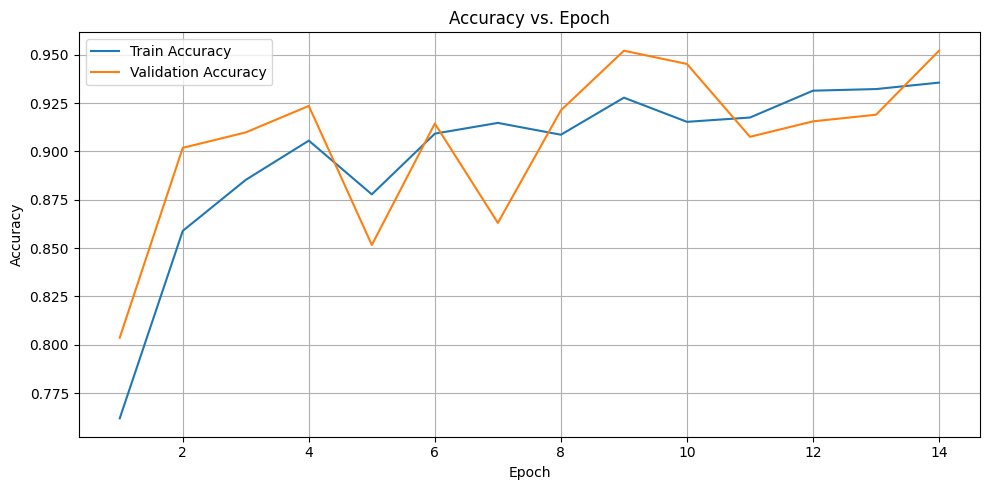

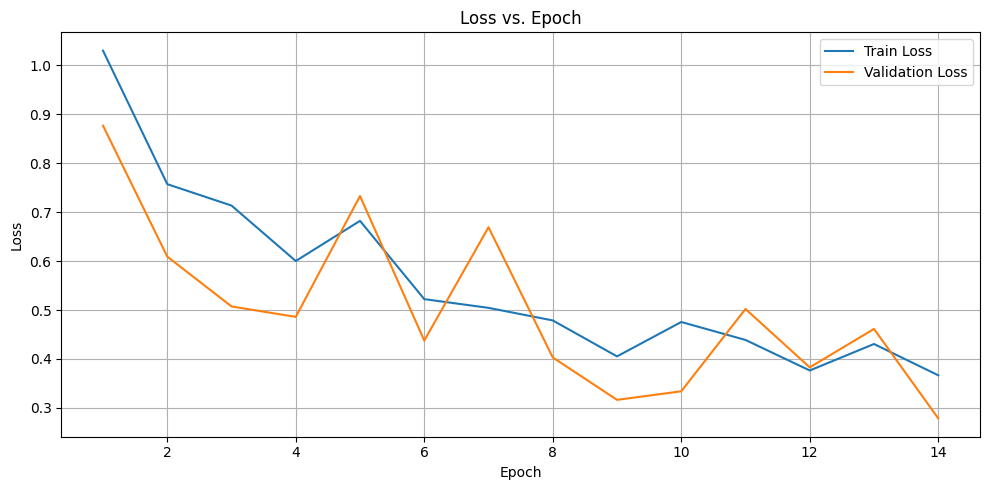

In [81]:
# Plot Accuracy vs Epoch
import matplotlib.pyplot as plt

epochs_range = range(1, len(train_accuracies) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("accuracy_vs_epoch.png")
plt.show()

# Plot Loss vs Epoch
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_vs_epoch.png")
plt.show()

In [54]:
class_map_str_to_int = {"Cloudy": 0, "Rain": 1, "Shine": 2, "Sunrise": 3}
index_to_class = {v: k for k, v in class_map_str_to_int.items()}
for x, y in test_loader:
    x = x.to(device)
    y = y.float().to(device)
    preds = model(x)
    preds=torch.softmax(preds,dim=1) #not used in model becuase of crossentropy loss

    preds=torch.argmax(preds,dim=1)

    predicted_classes = [index_to_class[int(i)] for i in preds]
    # Model learnt that which indices is which (compared to model fed OHE) via loss !
    print(predicted_classes)


['Shine', 'Shine', 'Sunrise', 'Cloudy', 'Sunrise', 'Sunrise']


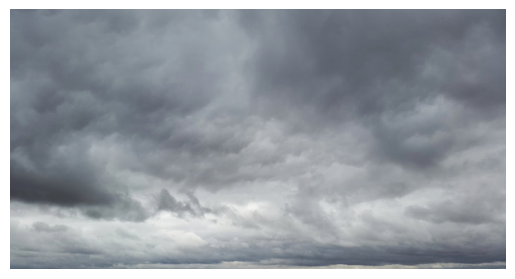

Cloudy


In [55]:
model.eval()
test_img=Image.open("/content/cloudy.jpg")
plt.imshow(test_img)
plt.axis('off')  # Hide axes
plt.show()
test_img=transforms_val(test_img).unsqueeze(0).to(device)
pred=model(test_img)
pred=torch.softmax(pred,dim=1)

pred=torch.argmax(pred,dim=1)
pred=index_to_class[int(pred)]
print(pred)

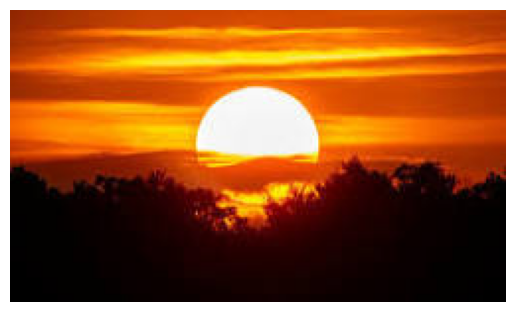

Sunrise


In [56]:
test_img=Image.open("/content/sunrise.jpg")
plt.imshow(test_img)
plt.axis('off')  # Hide axes
plt.show()
test_img=transforms_val(test_img).unsqueeze(0).to(device)
pred=model(test_img)
pred=torch.softmax(pred,dim=1)

pred=torch.argmax(pred,dim=1)
pred=index_to_class[int(pred)]
print(pred)

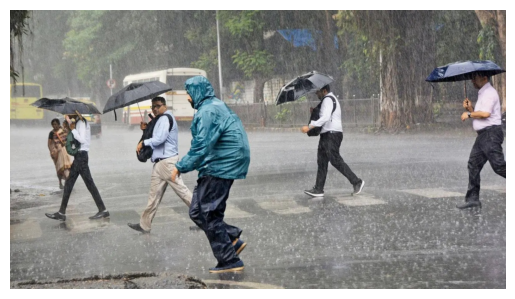

Rain


In [59]:
test_img=Image.open("/content/rain.jpg")
plt.imshow(test_img)
plt.axis('off')  # Hide axes
plt.show()
test_img=transforms_val(test_img).unsqueeze(0).to(device)
pred=model(test_img)
pred=torch.softmax(pred,dim=1)

pred=torch.argmax(pred,dim=1)
pred=index_to_class[int(pred)]
print(pred)

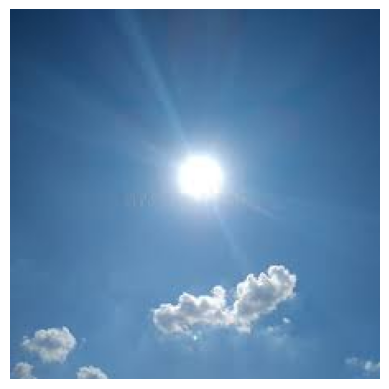

Shine


In [58]:
test_img=Image.open("/content/shine.jpg")
plt.imshow(test_img)
plt.axis('off')  # Hide axes
plt.show()
test_img=transforms_val(test_img).unsqueeze(0).to(device)
pred=model(test_img)
pred=torch.softmax(pred,dim=1)

pred=torch.argmax(pred,dim=1)
pred=index_to_class[int(pred)]
print(pred)